# Density estimation with Normalizing Flow

## Toy example

Use variables $\alpha$ and $\beta$ to define SR.

$$
p(\alpha) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\alpha^{2}}{2}}
$$

$$
p(\beta) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\beta^{2}}{2}}
$$

Use variable $y$ which has a weak dependence on $\alpha$ and $\beta$ for training and likelihood fitting.

$$
y = N( \mu = k\alpha + q\beta,\sigma = 1)
$$

In [31]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from tqdm import tqdm

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda:0" if CUDA else "cpu")

cuda available: True


In [82]:
%run plotting.py

<function matplotlib.pyplot.close(fig=None)>

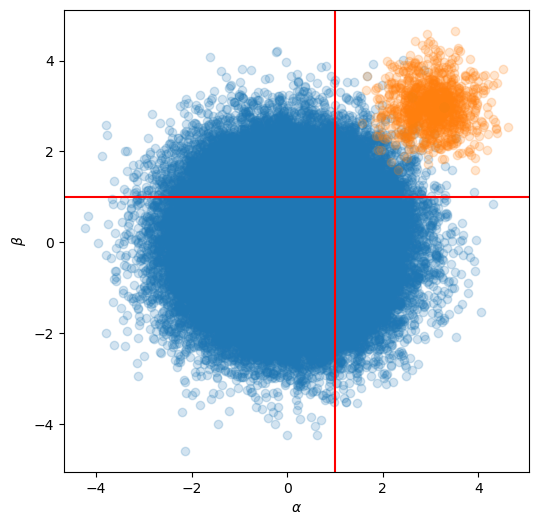

In [61]:
n1 = 100000
plt.figure(figsize=(6,6))
# Background
x1 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
x2 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.scatter(x1, x2, alpha = 0.2)
data = np.stack([x1, x2], axis = -1)
# Signal
n2 = 1000
x3 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
x4 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
plt.scatter(x3, x4, alpha = 0.2)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.show
plt.savefig('plots/full_bkg_sig.pdf')
plt.close

Blues shows the background events, and orange shows the signal events. The red lines define the CRs and SR. The upper right region is SR.

### Define the training model

In [4]:
%run SimpleMAF.py

### Generate the 2D gaussian distribution.

In [5]:
MAF1 = SimpleMAF(num_features = data.ndim)
MAF1.train(data, n_epochs=20, plot=False)

100%|==========| 20/20 [00:32<00:00,  1.62s/it]


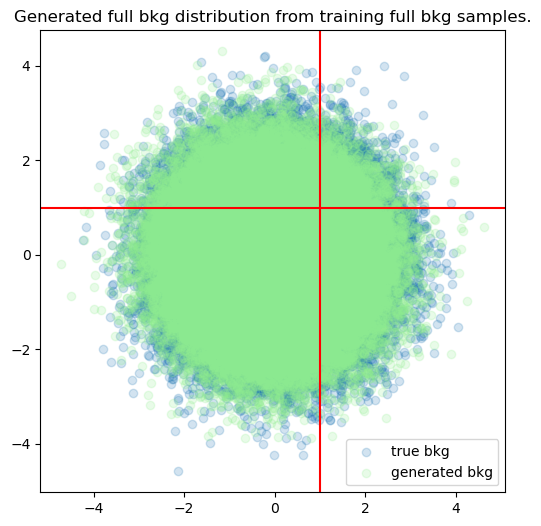

<Figure size 640x480 with 0 Axes>

In [65]:
samples_gen_full_bkg = MAF1.sample(n1)
plot_gen_full_bkg(samples_gen_full_bkg, x1, x2)

In [79]:
# Train on background distribution in CR
mask_CR = np.logical_not((data[:,0] > 1) & (data[:,1] > 1))
# Generate background distribution in SR
mask_SR = (x1 > 1) & (x2 > 1)

<function matplotlib.pyplot.close(fig=None)>

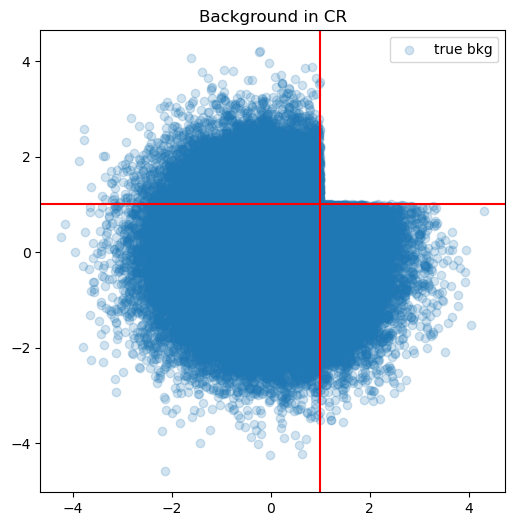

In [80]:
# Plot partial background that's been trained on
x1_CR = data[mask_CR][:,0]
x2_CR = data[mask_CR][:,1]
plt.figure(figsize=(6,6))
plt.scatter(x1_CR, x2_CR, alpha = 0.2, label = 'true bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.title("Background in CR")
plt.legend()
plt.show
plt.savefig('plots/train_CR_bkg.pdf')
plt.close

In [9]:
MAF2 = SimpleMAF(num_features = 2, num_cond_features = 2)
MAF2.train(data[mask_CR], cond=data[mask_CR], n_epochs=20, plot=False)

100%|==========| 20/20 [00:37<00:00,  1.86s/it]


In [10]:
samples_gen_SRfromCR_bkg = MAF2.sample(1, cond=data[mask_SR]).reshape((data[mask_SR].shape))

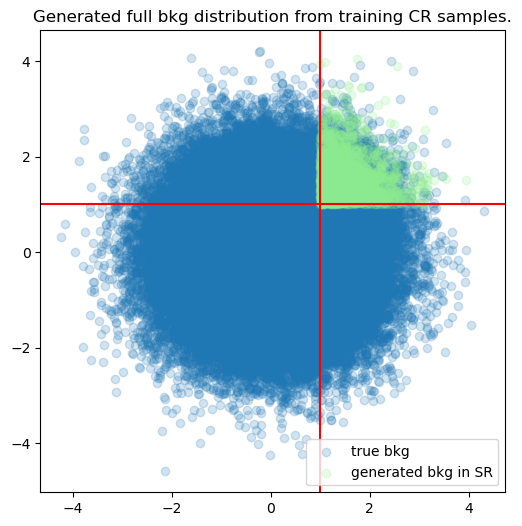

In [83]:
plot_gen_SRfromCR_bkg(samples_gen_SRfromCR_bkg, x1, x2)

### Generate $ y = N( \mu = k\alpha + q\beta,\sigma = 1)$

In [35]:
def Y(k, q, x1, x2):
    return np.random.normal(k*x1 + q*x2, 1, n1).astype(dtype=np.float32)

**y = random**

<function matplotlib.pyplot.close(fig=None)>

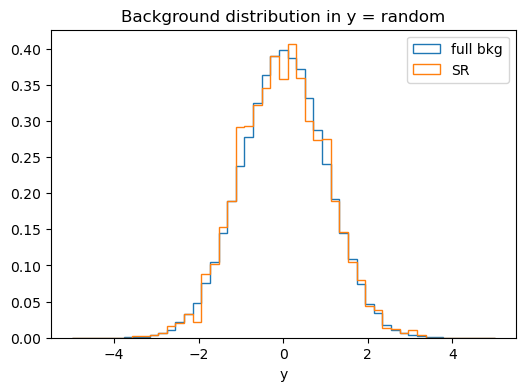

In [46]:
Y_rand = Y(0, 0, x1, x2)
plt.figure(figsize=(6,4))
bins = np.linspace(-5, 5, 50)
plt.hist(Y_rand, bins = bins, density = True, histtype='step', label='full bkg')
plt.hist(Y_rand[mask_SR], bins = bins, density = True, histtype='step', label='SR')
plt.title("Background distribution in y = random")
plt.xlabel("y")
plt.legend()
plt.show
plt.savefig('plots/full_bkg_in_y_random.pdf')
plt.close

In [14]:
cond_CR = np.stack([x1, x2], axis = -1)[mask_CR]

MAF3 = SimpleMAF(num_features = 1, num_cond_features = 2)
MAF3.train(data=Y_rand[mask_CR], cond=cond_CR, n_epochs=50, plot=False)

100%|==========| 50/50 [01:32<00:00,  1.84s/it]


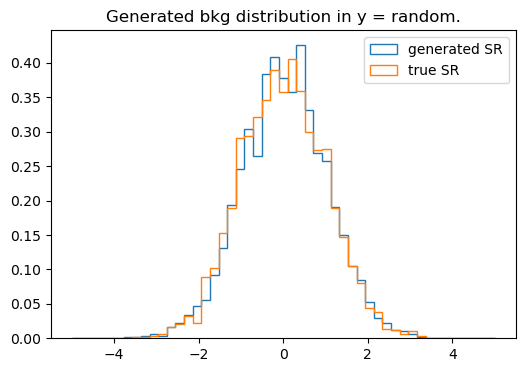

In [67]:
cond_SR = data[mask_SR]
samples_gen_SR_bkg_in_y_random = MAF3.sample(1, cond_SR).reshape(Y_rand[mask_SR].shape)
plot_gen_SR_bkg_in_y_random(samples_gen_SR_bkg_in_y_random, Y_rand[mask_SR])

**Increase dependence of $\alpha$ and $\beta$**

In [16]:
Y_cond2 = Y(0.2, 0.2, x1, x2)
Y_cond5 = Y(0.5, 0.5, x1, x2)
Y_cond8 = Y(0.8, 0.8, x1, x2)

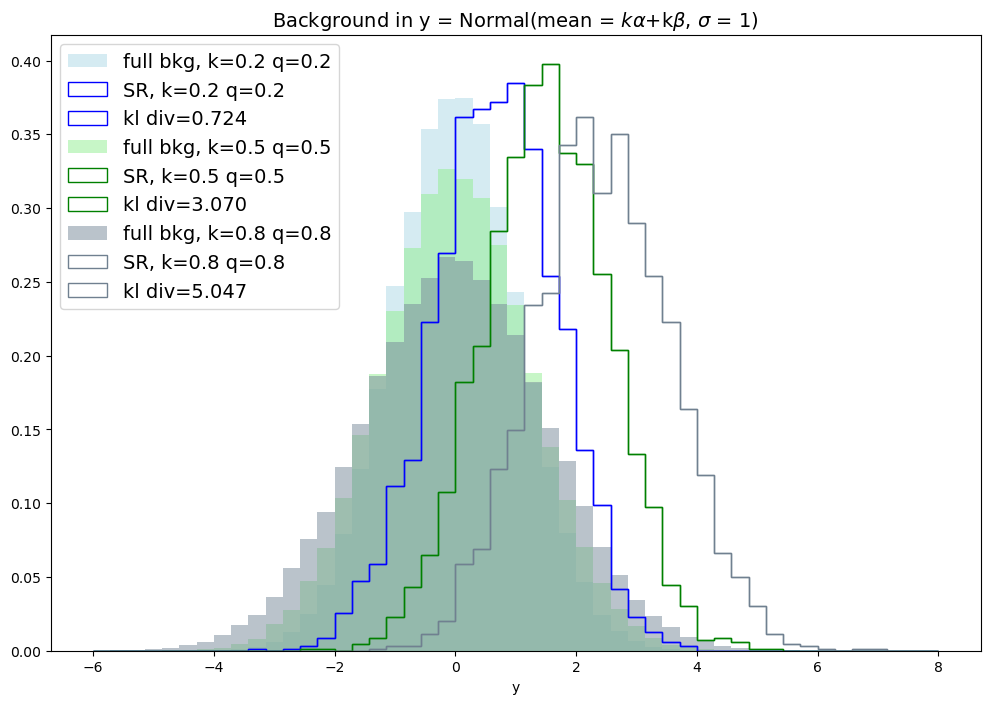

In [68]:
Y_cond_list = [Y_cond2, Y_cond5, Y_cond8]
Y_SR_list = [Y_cond2[mask_SR], Y_cond5[mask_SR], Y_cond8[mask_SR]]
k_list = [0.2, 0.5, 0.8]
plot_bkg_in_y_cond_list(Y_cond_list, Y_SR_list, "full bkg", "SR", k_list, k_list)

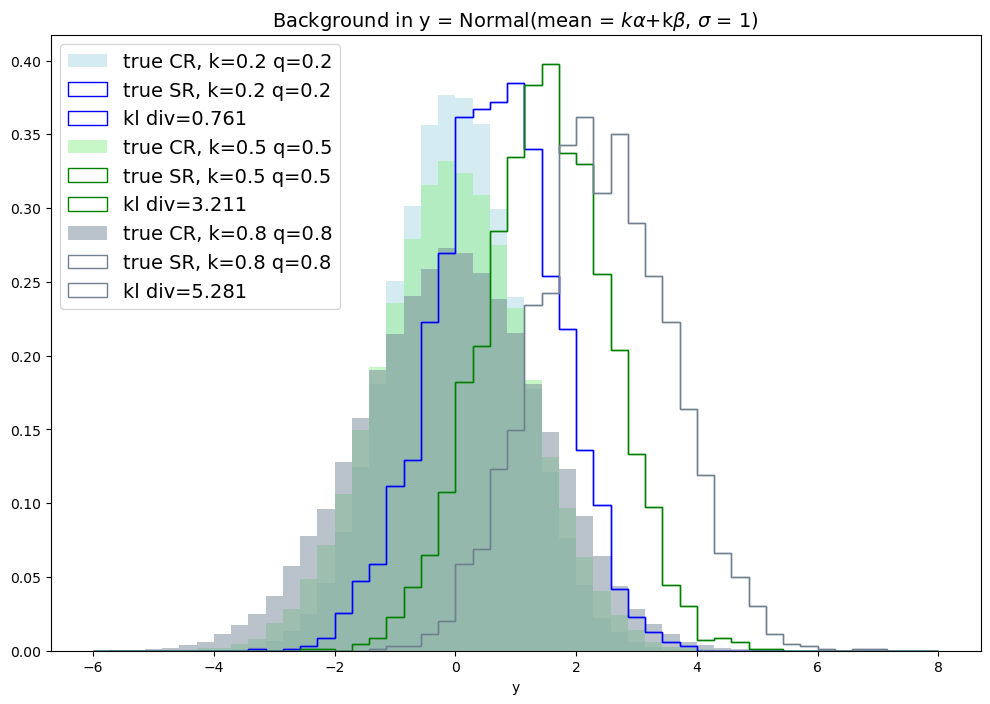

In [69]:
Y_cond_list = [Y_cond2[mask_CR], Y_cond5[mask_CR], Y_cond8[mask_CR]]
Y_SR_list = [Y_cond2[mask_SR], Y_cond5[mask_SR], Y_cond8[mask_SR]]
k_list = [0.2, 0.5, 0.8]
plot_bkg_in_y_cond_list(Y_cond_list, Y_SR_list, "true CR", "true SR", k_list, k_list)

In [20]:
MAF_c2 = SimpleMAF(num_features = 1, num_cond_features = 2)
MAF_c2.train(data=Y_cond2[mask_CR], cond=cond_CR, n_epochs=50, plot=False)

100%|==========| 50/50 [01:31<00:00,  1.83s/it]


In [21]:
MAF_c5 = SimpleMAF(num_features = 1, num_cond_features = 2)
MAF_c5.train(data=Y_cond5[mask_CR], cond=cond_CR, n_epochs=50, plot=False)

100%|==========| 50/50 [01:31<00:00,  1.82s/it]


In [22]:
MAF_c8 = SimpleMAF(num_features = 1, num_cond_features = 2)
MAF_c8.train(data=Y_cond8[mask_CR], cond=cond_CR, n_epochs=50, plot=False)

100%|==========| 50/50 [01:31<00:00,  1.84s/it]


In [23]:
samples_c2 = MAF_c2.sample(1, cond_SR).reshape(Y_cond2[mask_SR].shape)
samples_c5 = MAF_c5.sample(1, cond_SR).reshape(Y_cond5[mask_SR].shape)
samples_c8 = MAF_c8.sample(1, cond_SR).reshape(Y_cond8[mask_SR].shape)

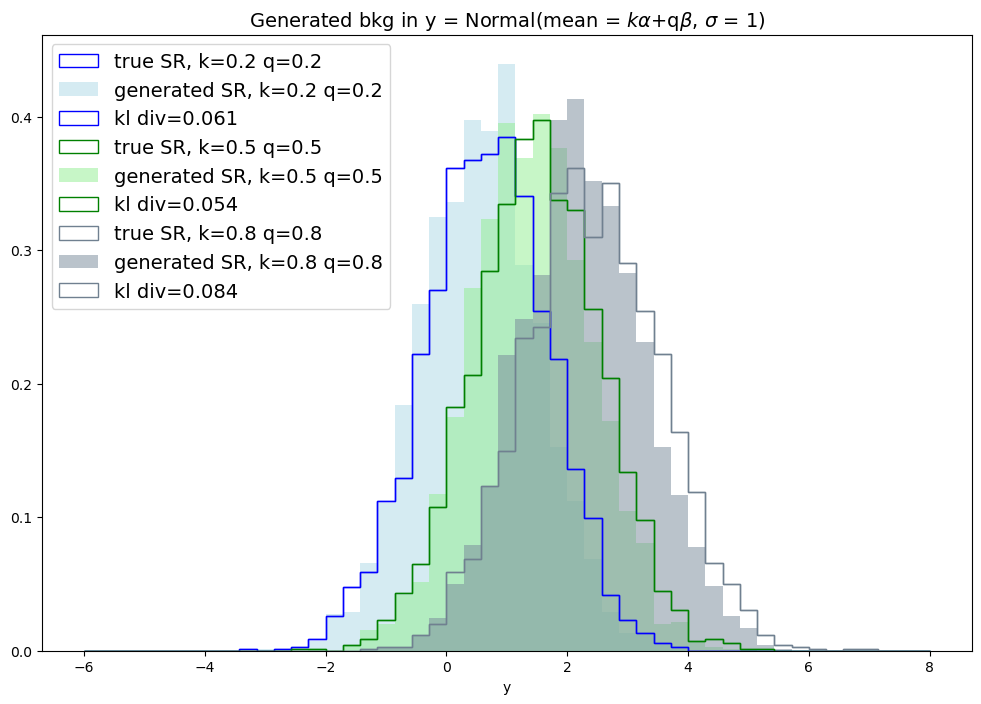

In [70]:
samples_list = [samples_c2, samples_c5, samples_c8]
plot_gen_SR_bkg_in_y_cond_list(samples_list, Y_SR_list, k_list, k_list)

## Toy example 1D

<function matplotlib.pyplot.close(fig=None)>

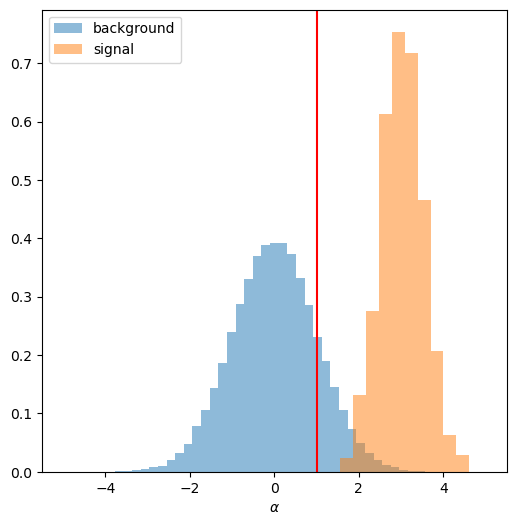

In [62]:
plt.figure(figsize=(6,6))
bins = np.linspace(-5, 5, 50)
# Background
data1D = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.hist(data1D, bins=bins, density=True, alpha = 0.5, label="background")
# Signal
plt.hist(x3, density=True, alpha = 0.5, label="signal")
plt.xlabel('$\\alpha$')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.show()
plt.savefig('plots/full_bkg_sig_1D.pdf')
plt.close

In [26]:
MAF1D = SimpleMAF(num_features = 1)
MAF1D.train(data=data1D, n_epochs=20, plot=False)

100%|==========| 20/20 [00:31<00:00,  1.58s/it]


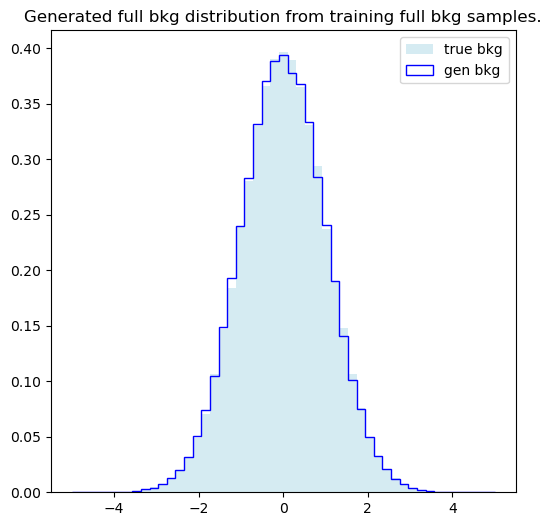

<function matplotlib.pyplot.close(fig=None)>

In [27]:
sample1D  = MAF1D.sample(n1)
plt.figure(figsize=(6,6))
plt.hist(data1D, bins=bins, density=True, histtype='stepfilled', alpha = 0.5, color = 'lightblue', label="true bkg")
plt.hist(sample1D, bins=bins, density=True, histtype='step', color = "blue", label="gen bkg")
plt.legend()
plt.title("Generated full bkg distribution from training full bkg samples.")
plt.show()
plt.close

### Generate $ y = N( \mu = k\alpha,\sigma = 1)$

In [72]:
def Y_1D(k, x1):
    return np.random.normal(k*x1, 1, n1).astype(dtype=np.float32)

In [73]:
Y1D = Y_1D(0.5, data1D)
mask_train1D = data1D < 1
mask_gen1D = data1D > 1

MAF1D_cond = SimpleMAF(num_features = 1, num_cond_features=1)
MAF1D_cond.train(data=Y1D[mask_train1D], cond=data1D[mask_train1D], n_epochs=50, plot=False)

100%|==========| 50/50 [01:23<00:00,  1.67s/it]


<function matplotlib.pyplot.close(fig=None)>

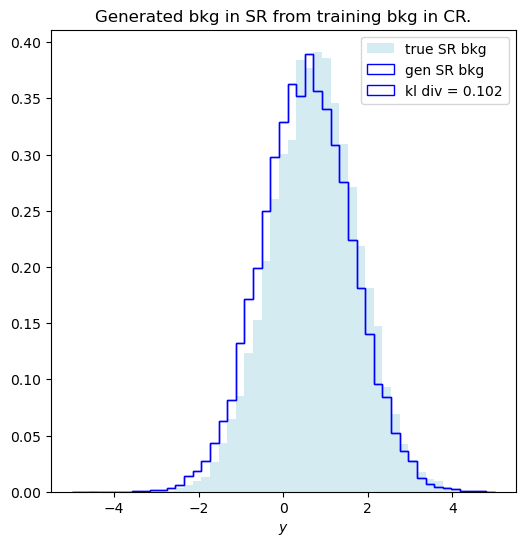

In [76]:
sample1D_cond = MAF1D_cond.sample(num_samples=1, cond=data1D[mask_gen1D].reshape(-1,1)).reshape((data1D[mask_gen1D].shape))
plt.figure(figsize=(6,6))
c0, cbins, _  = plt.hist(Y1D[mask_gen1D], bins=bins, density=True, histtype='stepfilled', alpha = 0.5, color = 'lightblue', label="true SR bkg")
c1, cbins, _  = plt.hist(sample1D_cond, bins=bins, density=True, histtype='step', color = "blue", label="gen SR bkg")
kl_div = get_kl_div(c0,c1)
plt.hist(sample1D_cond, bins=bins, density=True, histtype='step', color = "blue", label=f"kl div = {kl_div:.3f}")
plt.legend()
plt.xlabel("$y$")
plt.title(f"Generated bkg in SR from training bkg in CR.")
plt.show
plt.savefig('plots/gen_SR_bkg_in_y_cond1D.pdf')
plt.close

Extrapolation in 1D doesn't work as well as in 2D.